In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [7]:
with h5py.File(PCA_PATH, 'r') as f:
    flux = f['flux'][()]
    flux_idx = f['flux_idx'][()]
    Fe_H = f['Fe_H'][()]
    log_g = f['log_g'][()]
    O_M = f['O_M'][()]
    C_M = f['C_M'][()]
    T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]


In [8]:
flux0 = flux[flux_idx]

In [9]:
flux0.shape

(38432, 1000)

In [10]:
(Fe, Te, Lg, CM, OM) =  np.where(flux_idx)
para = pd.DataFrame(data=np.transpose([Fe, Te, Lg, CM, OM]), columns = ["Fe", "Te", "Lg", "CM", "OM"])

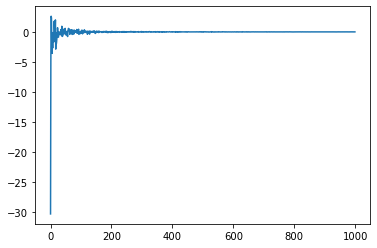

In [13]:
plt.plot(flux0[0])

In [39]:
para.to_csv("./para.csv")

In [14]:
flux200 = flux0[:,:200]

In [10]:
DATA_PATH = os.path.join(DATA_DIR, 'pc200.h5')
with h5py.File(DATA_PATH, 'r') as f:
    flux = f['flux'][()]
#     flux32m = f['flux32m'][()]
#     flux32ms = f['flux32ms'][()]
#     fmean =  f['fmean'][()]
#     fm_std = f['fm_std'][()]

In [15]:
flux200.shape

(38432, 200)

In [18]:
flux200.std()

4.859319962411908

In [16]:
DATA_PATH = os.path.join(DATA_DIR, 'pc200.h5')
with h5py.File(DATA_PATH, 'w') as f:
    f.create_dataset('flux', data = flux200, shape = flux200.shape)
#     f.create_dataset('fm_std', data = std, shape = (1,))  

In [12]:
flux32ms.shape

(116614, 32)

### LOADING MODEL

In [34]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pc200.h5",
      "train": "flux"
    },
    "model":{
      "type": "ae",
      "stddev": 0.01,
      "aug": 1,
      "name": "LowT",
      "input_dim": 200,
      "latent_dim": 32,
      "hidden_dims": [256, 128, 64],
      "dropout": 0.01,
      "lr": 0.003,
      "reg1": 0.001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 100,
      "batch_size": 256,
      "validation_split":0.3,
      "logdir": "fit",
      "verbose": 1,
      "save": 0
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
  }
config = DotMap(config_dict)

In [14]:
#  loss: 0.0113 
# - mean_squared_error: 0.0023 
# - val_loss: 0.0337 
# - val_mean_squared_error: 0.0248

In [27]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [35]:
mm = SimpleAEModel()
mm.build_model(config)

In [36]:
data = flux200
tt = SimpleAETrainer(mm, config)
h=tt.train((data, data), ep=100)

Epoch 1/100
106/106 [==============================] - 2s 13ms/step - loss: 2.3533 - mean_squared_error: 1.5578 - val_loss: 1.9002 - val_mean_squared_error: 1.2194
Epoch 2/100
106/106 [==============================] - 0s 5ms/step - loss: 0.8746 - mean_squared_error: 0.2780 - val_loss: 1.4454 - val_mean_squared_error: 0.9254
Epoch 3/100
106/106 [==============================] - 1s 5ms/step - loss: 0.6620 - mean_squared_error: 0.1965 - val_loss: 1.0378 - val_mean_squared_error: 0.6238
Epoch 4/100
106/106 [==============================] - 1s 6ms/step - loss: 0.5343 - mean_squared_error: 0.1593 - val_loss: 0.8726 - val_mean_squared_error: 0.5329
Epoch 5/100
106/106 [==============================] - 1s 5ms/step - loss: 0.4482 - mean_squared_error: 0.1357 - val_loss: 0.9254 - val_mean_squared_error: 0.6377
Epoch 6/100
106/106 [==============================] - 1s 6ms/step - loss: 0.3964 - mean_squared_error: 0.1275 - val_loss: 0.8099 - val_mean_squared_error: 0.5597
Epoch 7/100
106/106 [

In [37]:
def plot_err(org, rec):
    f, axs =  plt.subplots(2, 4,figsize=(20, 10))
    for idx, ax in enumerate(axs.flatten()):
        ax.scatter(org[:, idx],rec[:, idx], s=0.1, color  = 'r')
        ax.set_xlabel(f"PC - {idx + 1}")
        ax.set_ylabel(f"AE - {idx + 1} ")
        ax.grid(1)

In [41]:
tt.eval(eigv[:,:200])

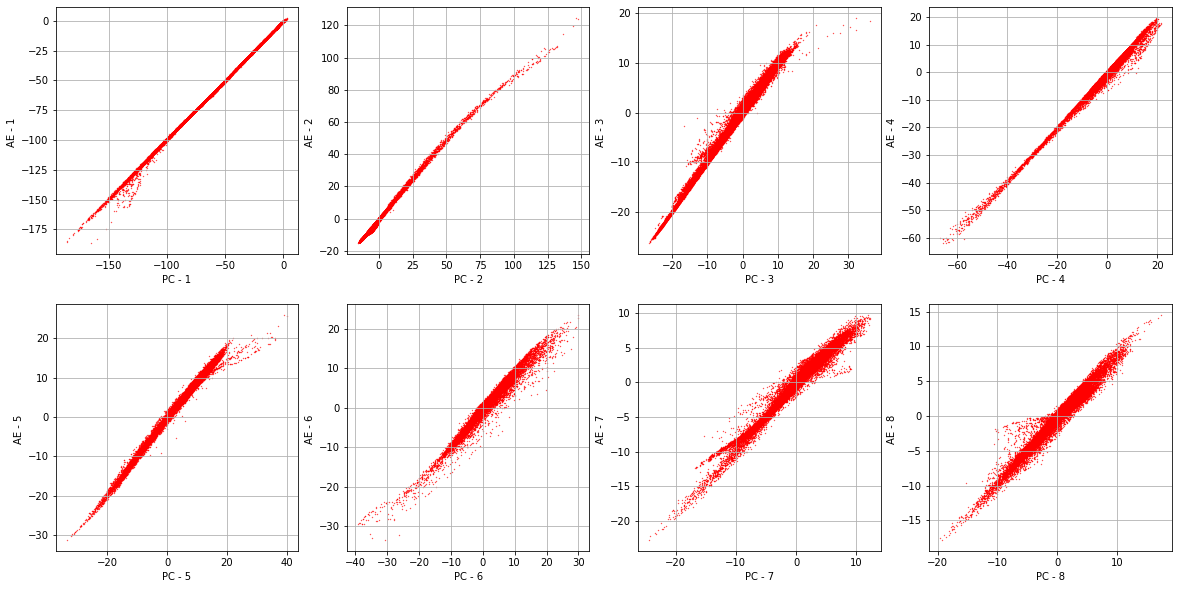

In [42]:
plot_err(tt.x_train, tt.ae_pred)

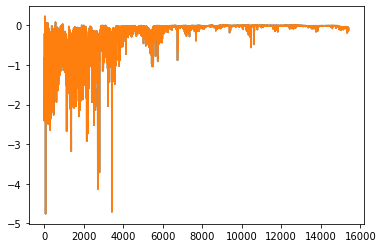

In [47]:
plt.plot(tt.flux_org[100])
plt.plot( tt.flux_org[100])

In [45]:
# plot_err(tt.flux_org, tt.flux_rec)

In [48]:
l = mm.encode(tt.x_train)

In [49]:
l.shape

TensorShape([38432, 32])

In [50]:
import umap

In [53]:
umap_dim = 5
# umap_results = umap.UMAP(n_neighbors=1000, min_dist=0.1, n_components=umap_dim).fit_transform(l)

In [54]:
for i in range(umap_dim):
    para[f'u{i}'] = umap_results[:,i]

In [58]:
import seaborn as sns

/datascope/slurm/miniconda3/envs/ae-tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='u0', ylabel='u1'>

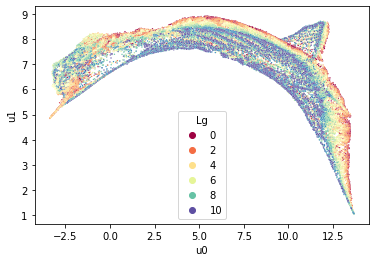

In [59]:
sns.scatterplot( "u0", "u1", data=para,hue="Lg", palette="Spectral", s=2, )
# plt.legend(markerscale=0.5,bbox_to_anchor=(1.05, 1),title="FeH",)

In [60]:
def plot_model(df, para, type):
    sns.pairplot(
        df,
        x_vars=[f"{type}{i}" for i in range(1,6)],
        y_vars=[f"{type}{i}" for i in range(1,6)],
        hue=para,
        plot_kws=dict(marker="o", s=2, edgecolor="none"),
        diag_kws=dict(fill=False, alpha=0.3),
        palette="Spectral"
    )

In [ ]:
sns.pairplot(
        para,
        x_vars=[f"u{i}" for i in range(umap_dim)],
        y_vars=[f"u{i}" for i in range(umap_dim)],
        hue="L",
        plot_kws=dict(marker="o", s=2, edgecolor="none"),
        diag_kws=dict(fill=False, alpha=0.3),
        palette="Spectral",
        corner=1
    )

In [ ]:
sns.pairplot(
        para,
        x_vars=[f"u{i}" for i in range(umap_dim)],
        y_vars=[f"u{i}" for i in range(umap_dim)],
        hue="Fe",
        plot_kws=dict(marker="o", s=2, edgecolor="none"),
        diag_kws=dict(fill=False, alpha=0.3),
        palette="Spectral",
        corner=1
    )

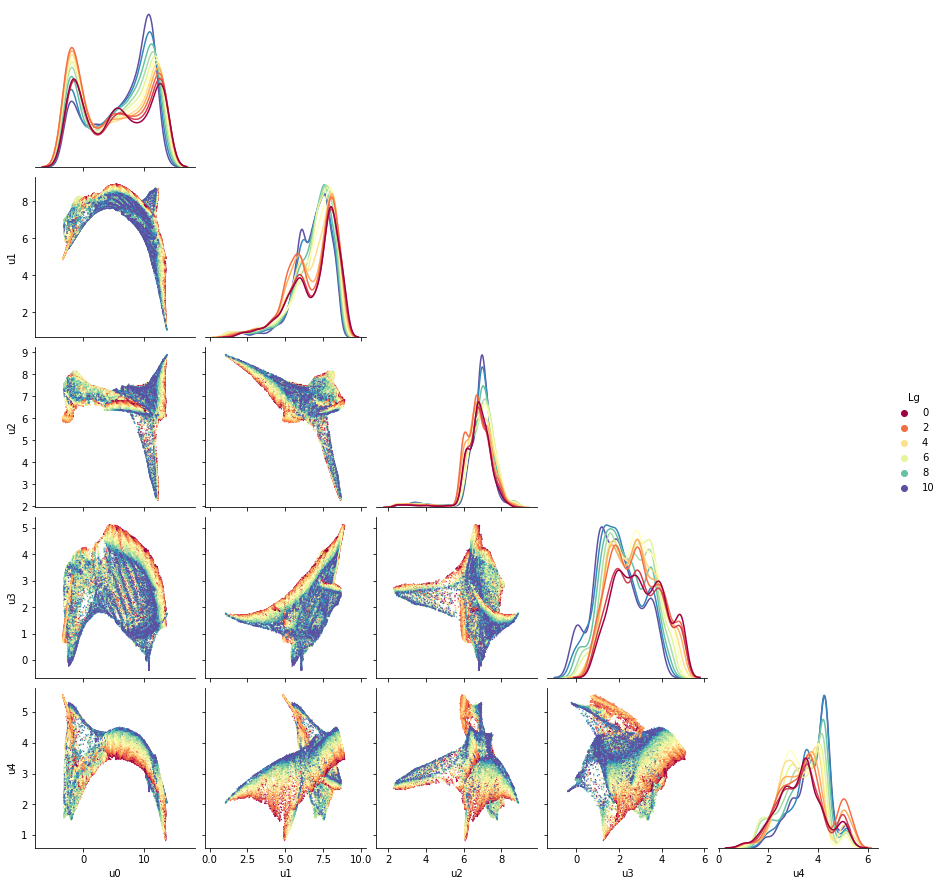

In [62]:
sns.pairplot(
        para,
        x_vars=[f"u{i}" for i in range(umap_dim)],
        y_vars=[f"u{i}" for i in range(umap_dim)],
        hue="Lg",
        plot_kws=dict(marker="o", s=2, edgecolor="none"),
        diag_kws=dict(fill=False, alpha=0.3),
        palette="Spectral",
        corner=1
    )

In [ ]:
sns.pairplot(dfen, hue="Teff", palette="Spectral")

In [18]:
# MODEL_PATH="/home/swei20/AE/trained_model/ep200_mse_lr2_32_l8_h128_h32_INleEMleHDle_pc32_ms0708_105250/"
MODEL_PATH="/home/swei20/AE/trained_model/ep300_mse_lr0001_32_l5_h512_h128_INleEMleHDle_pc32ms_r50710_182419/"
# MODEL_PATH="/home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0707_143841/"
mm.load(MODEL_PATH)

Loading model checkpoint /home/swei20/AE/trained_model/ep300_mse_lr0001_32_l5_h512_h128_INleEMleHDle_pc32ms_r50710_182419/ ...

Model loaded
